In [1]:
# Load library imports
import sys
import torch
import random
import joblib
import logging
import importlib
import numpy as np
import pandas as pd

# Load project Imports
from src.utils.config_loader import load_project_config
from src.data_ingestion.gwl_data_ingestion import process_station_coordinates, \
    fetch_and_process_station_data, download_and_save_station_readings
from src.preprocessing.gwl_preprocessing import load_timeseries_to_dict, outlier_detection, \
    resample_daily_average, remove_spurious_data, interpolate_short_gaps, handle_short_gaps
from src.preprocessing.gap_imputation import handle_large_gaps
from src.preprocessing.gwl_feature_engineering import build_lags, build_seasonality_features, \
    trim_and_save

In [2]:
# Set up logging config
logging.basicConfig(
    level=logging.INFO,
   format='%(levelname)s - %(message)s',
#    format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)

# Set up logger for file and load config file for paths and params
logger = logging.getLogger(__name__)
config = load_project_config(config_path="config/project_config.yaml")
notebook = True

# Set up seeding to define global states
random_seed = config["global"]["pipeline_settings"]["random_seed"]
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define notebook demo catchment
catchments_to_process = config["global"]["pipeline_settings"]["catchments_to_process"]
catchment = catchments_to_process[0]
run_defra_API_calls = config["global"]["pipeline_settings"]["run_defra_api"]  # True to run API calls

logging.info(f"Show Notebook Outputs: {notebook}")
logging.info(f"Notebook Demo Catchment: {catchment.capitalize()}")

INFO - Loading configuration from: /Users/charlotte/Desktop/Dissertation_Code/config/project_config.yaml
INFO - Show Notebook Outputs: True
INFO - Notebook Demo Catchment: Eden


### DATA INGESTION ###

Load gwl station list with grid references and convert grid references to easting, northing, longitude and latitude form for plotting and data alignment.

In [3]:
# --- Process Catchment Stations List ----
stations_with_coords_df = process_station_coordinates(
    os_grid_squares=config["global"]["paths"]["gis_os_grid_squares"],
    station_list_input=config[catchment]["paths"]["gwl_station_list"],
    station_list_output=config[catchment]["paths"]["gwl_station_list_with_coords"],
    catchment=catchment
)

logger.info(f"Pipeline step 'Process Station Coordinates for {catchment}' complete.\n")

INFO - [eden] Starting coordinate processing for station list...

INFO - [eden] Loaded OS grid squares lookup from: data/01_raw/global/os_grid_squares.csv
INFO - [eden] Loaded station list from: data/01_raw/eden/gwl_stations/station_list.csv
INFO - [eden] Converted OS grid references to coordinates for 17 stations.

INFO - [eden] Saved processed station list to: data/02_processed/eden/gwl_station_data/station_list_with_coords.csv
INFO - Station location reference table head:

  station_id    station_name    grid_ref   easting  northing        lat  \
0     NY36_2        longtown  NY39146790  339140.0  567900.0  55.001931   
1     NY46_3         scaleby  NY46526426  346520.0  564260.0  54.970074   
2    NY55_71  castle_carrock  NY53825337  353820.0  553370.0  54.872953   
3    NY54_54         croglin  NY56354839  356350.0  548390.0  54.828432   
4    NY54_10       ainstable  NY52574645  352570.0  546450.0  54.810655   

        lon  
0 -2.952971  
1 -2.836931  
2 -2.721158  
3 -2.680981 

**API Documentation notes:**

1. The API calls that return readings data have a soft limit of 100,000 rows per-call which can be overridden by setting a _limit parameter. There is a hard limit of 2,000,000 rows, which cannot be overridden.
2. The primary identifier for most stations uses a GUID style identifier called an SUID. These are used in the URL for the station and given as the value of the notation property in the station metadata.  
    a. Wiski identifier (wiskiID) is also available for my subset of stations and data type  
3. All monitoring stations can be filtered by name, location and other parameters. See https://environment.data.gov.uk/hydrology/doc/reference#stations-summary for full metadata details

In [4]:
if run_defra_API_calls:
    # Retrieve gwl monitoring station metadata and measures from DEFRA API
    stations_with_metadata_measures = fetch_and_process_station_data(
        stations_df=stations_with_coords_df,
        base_url=config["global"]["paths"]["defra_station_base_url"],
        output_path=config[catchment]["paths"]["gwl_station_metadata_measures"]
    )

    logger.info(f"Pipeline step 'Pull Hydrological Station Metadata for {catchment}' complete.\n")

    stations_with_metadata_measures.head()

In [5]:
if run_defra_API_calls:
    download_and_save_station_readings(
        stations_df=stations_with_metadata_measures,
        start_date=config["global"]["data_ingestion"]["api_start_date"],
        end_date=config["global"]["data_ingestion"]["api_end_date"],
        gwl_data_output_dir=config[catchment]["paths"]["gwl_data_output_dir"]
    )

    logger.info(f"All timeseries groundwater level data saved for {catchment} catchment.")
    
else:
    
    loaded_csv_path = config[catchment]["paths"]["gwl_station_metadata_measures"]
    stations_with_metadata_measures = pd.read_csv(loaded_csv_path)

### PREPROCESSING ###

Remove stations with insufficient data and clean ts data from outliers and incorrect measurements. Interpolate between small data gaps using rational spline.

1. Load station df's into dict, dropping catchments with insufficient data

In [6]:
# Load timeseries CSVs from API into reference dict
gwl_time_series_dict = load_timeseries_to_dict(
    stations_df=stations_with_metadata_measures,
    col_order=config["global"]["data_ingestion"]["col_order"],
    data_dir=config[catchment]["paths"]["gwl_data_output_dir"],
    inclusion_threshold=config[catchment]["preprocessing"]["inclusion_threshold"]
)

logger.info(f"All timeseries data converted to dict for {catchment} catchment.\n")

INFO - Converting API csv data to reference dict...

INFO - longtown successfully saved to dict.
INFO - scaleby successfully saved to dict.
INFO - castle_carrock successfully saved to dict.
INFO - croglin successfully saved to dict.
INFO - ainstable successfully saved to dict.
INFO - baronwood successfully saved to dict.
INFO - renwick successfully saved to dict.
INFO - east_brownrigg successfully saved to dict.
INFO - bgs_ev2 successfully saved to dict.
INFO - Station penrith_north contained insufficient data -> dropping dataframe.(41 < 5000)
INFO - skirwith successfully saved to dict.
INFO - cliburn_town_bridge_1 successfully saved to dict.
INFO - cliburn_town_bridge_2 successfully saved to dict.
INFO - hilton successfully saved to dict.
INFO - coupland successfully saved to dict.
INFO - great_musgrave successfully saved to dict.
INFO - east_curthwaite successfully saved to dict.
INFO - 16 stations saved to dict.

INFO - All timeseries data converted to dict for eden catchment.



2. Remove outlying and incorrect data points

INFO - Station ainstable: Shifted values by +0.4654 between 2021-06-16 and 2021-11-17.
INFO - Station ainstable: Inverted segment between 2022-08-01 and 2023-04-18 around mean = 84.7347
INFO - Station ainstable: Shifted values by +-0.5928 between 2022-08-01 and 2023-04-18.
Removed data for range: 2021-06-13 to 2021-06-17
Removed data for range: 2021-11-15 to 2021-11-19
Removed data for range: 2023-04-16 to 2023-04-20
INFO - ainstable time series data in daily timestep saved to results/figures/eden/time_series/ainstable_aggregated_daily.png.

INFO - Station renwick: Removed 6961 data points between 2023-01-06 and 2023-10-23.
INFO - renwick time series data in daily timestep saved to results/figures/eden/time_series/renwick_aggregated_daily.png.

INFO - Station east_brownrigg: Removed 3169 data points between 2014-11-02 and 2015-03-14.
INFO - east_brownrigg time series data in daily timestep saved to results/figures/eden/time_series/east_brownrigg_aggregated_daily.png.



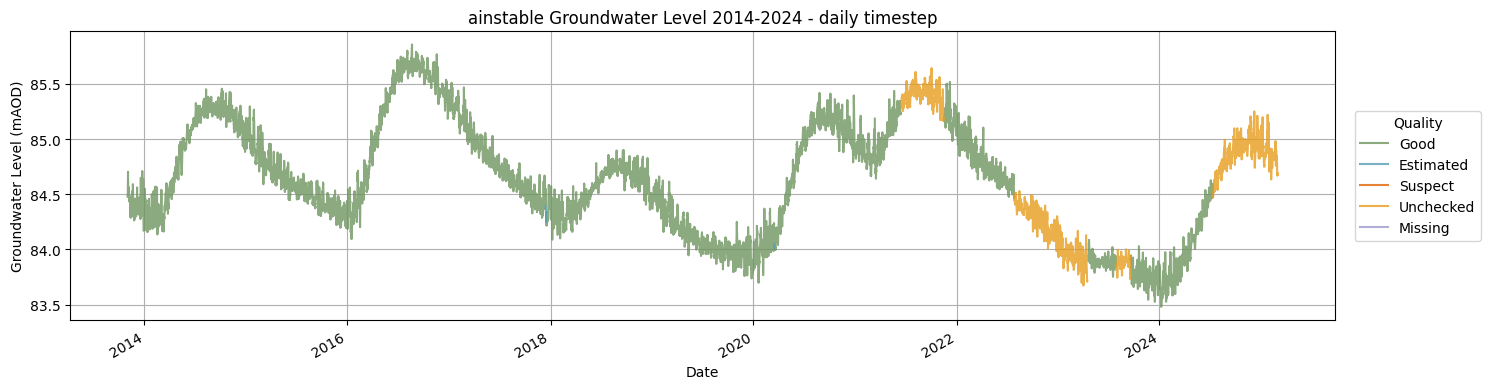

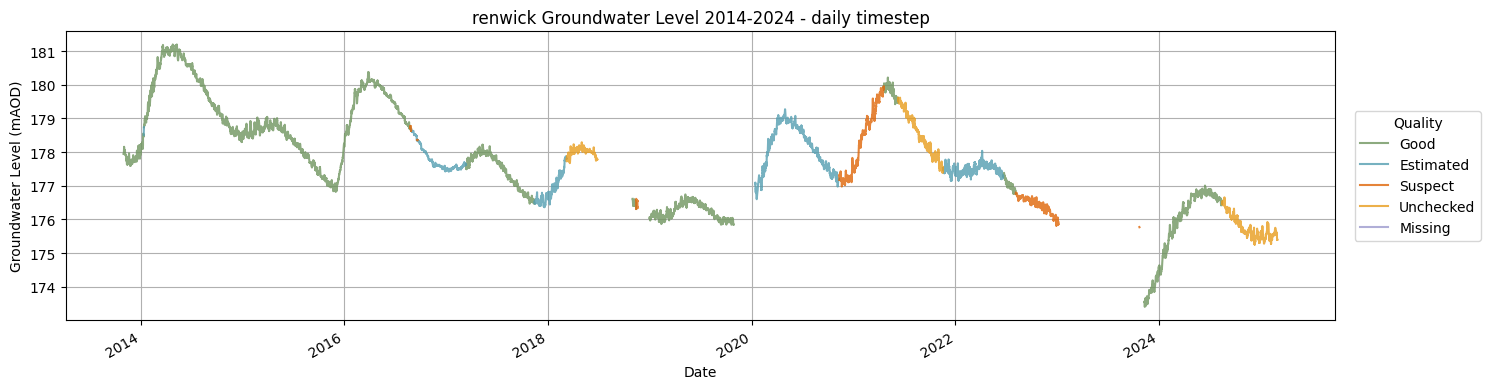

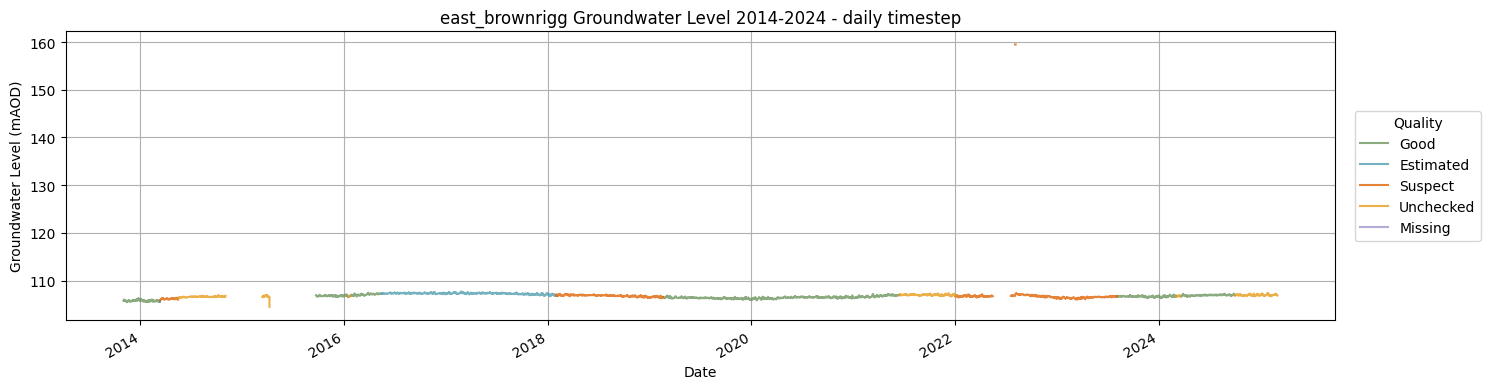

In [7]:
for station_name, df in gwl_time_series_dict.items():
    gwl_time_series_dict[station_name] = remove_spurious_data(
        target_df=df,
        station_name=station_name,
        path=config[catchment]["visualisations"]["ts_plots"]["time_series_gwl_output"],
        notebook=notebook
    )

In [8]:
run_outlier_processing = config["global"]["pipeline_settings"]["run_outlier_detection"]

if run_outlier_processing:
    # run outlier detection and processing
    processed_gwl_time_series_dict = outlier_detection(
        gwl_time_series_dict=gwl_time_series_dict,
        output_path=config[catchment]["visualisations"]["ts_plots"]["time_series_gwl_output"],
        dpi=config[catchment]["visualisations"]["ts_plots"]["dpi_save"],
        dict_output=config[catchment]["paths"]["gwl_outlier_dict"],
        notebook=notebook
    )

3. Aggregate to daily time steps

In [ ]:
if not run_outlier_processing:
    input_dict = config[catchment]["paths"]["gwl_outlier_dict"]
    processed_gwl_time_series_dict = joblib.load(input_dict)

daily_data = resample_daily_average(
    dict=processed_gwl_time_series_dict,
    start_date=config["global"]["data_ingestion"]["api_start_date"],
    end_date=config["global"]["data_ingestion"]["api_end_date"],
    path=config[catchment]["visualisations"]["ts_plots"]["time_series_gwl_output"],
    notebook=notebook
)

INFO - Initalising resampling of gwl data to daily timestep.

INFO - Resampling longtown to daily timestep...
INFO -     longtown resampled -> now contains 4107 non-zero data points.
INFO -     Data covers 99.3% of time period.

INFO - Resampling scaleby to daily timestep...
INFO -     scaleby resampled -> now contains 3816 non-zero data points.
INFO -     Data covers 92.2% of time period.

INFO - Resampling castle_carrock to daily timestep...
INFO -     castle_carrock resampled -> now contains 3972 non-zero data points.
INFO -     Data covers 96.0% of time period.

INFO - Resampling croglin to daily timestep...
INFO -     croglin resampled -> now contains 3865 non-zero data points.
INFO -     Data covers 93.4% of time period.

INFO - Resampling ainstable to daily timestep...
INFO -     ainstable resampled -> now contains 4123 non-zero data points.
INFO -     Data covers 99.6% of time period.

INFO - Resampling baronwood to daily timestep...
INFO -     baronwood resampled -> now contai

4. Interpolate across small gaps in the ts data using rational spline or PCHIP - try both (& define threshold n/o missing time steps for interpolation eligibility) + Add binary interpolation flag column

In [ ]:
daily_data, gaps_list, station_max_gap_lengths_calculated = handle_short_gaps(
    daily_data=daily_data,
    path=config[catchment]["visualisations"]["ts_plots"]["time_series_gwl_output"],
    max_steps=config["global"]["data_ingestion"]["max_interp_length"],
    start_date=config["global"]["data_ingestion"]["api_start_date"],
    end_date=config["global"]["data_ingestion"]["api_end_date"],
    notebook=notebook
)

Handle large gaps

In [ ]:
synthetic_imputation_performace, cleaned_df_dict = handle_large_gaps(
    df_dict=daily_data,
    gaps_list=gaps_list,
    catchment=catchment,
    spatial_path=config[catchment]["paths"]["gwl_station_list_with_coords"],
    path=config[catchment]["visualisations"]["ts_plots"]["time_series_gwl_output"],
    threshold_m=config[catchment]["preprocessing"]["large_catchment_threshold_m"],
    radius=config["global"]["preprocessing"]["radius"],
    output_path=config[catchment]["visualisations"]["corr_dist_score_scatters"],
    threshold=config[catchment]["preprocessing"]["dist_corr_score_threshold"],
    predefined_large_gap_lengths=config["global"]["preprocessing"]["gap_lengths_days"] ,
    max_imputation_length_threshold=config["global"]["preprocessing"]["max_imputation_threshold"],
    min_around=config["global"]["preprocessing"]["min_data_points_around_gap"],
    station_max_gap_lengths=station_max_gap_lengths_calculated,
    k_decay=config[catchment]["preprocessing"]["dist_corr_score_k_decay"],
    random_seed=config["global"]["pipeline_settings"]["random_seed"]
)

5. Lagged: Add lagged features (by timestep across 7 days?) + potentially rolling averages (3-day/7-day?) + THEN trim

In [ ]:
df_with_lags = build_lags(
 df_dict=cleaned_df_dict,
 catchment=catchment
)

df_with_seasons = build_seasonality_features(
 df_dict=df_with_lags,
 catchment=catchment
)

trimmed_df_dict = trim_and_save(
    df_dict=df_with_seasons,
    model_start_date=config['global']['data_ingestion']['model_start_date'],
    model_end_date=config['global']['data_ingestion']['model_end_date'],
    trimmed_output_dir=config[catchment]["paths"]["trimmed_output_dir"],
    ts_path=config[catchment]["visualisations"]["ts_plots"]["time_series_gwl_output"],
    notebook=notebook
)

In [ ]:
for station, df in trimmed_df_dict.items():
    print(f"\n{station:}")
    print(df.head(10))

In [ ]:
NaN_list = {station: [] for station in trimmed_df_dict.keys()}

for station, df in trimmed_df_dict.items():

    # Loop through columns
    for col in df.columns:
        num_nans = df[col].isna().sum()
        if num_nans > 0:
            print(f"\n{station:}\n{col}: {num_nans} NaNs")
        
    # Loop through rows
    for idx, row in df.iterrows():
        if row.isna().any():
            NaN_list[station].append({
                'index': idx,
                'data_type': row['data_type']
            })

for station, dict in NaN_list.items():
    if len(dict) > 0:
        print(f"\n{station}:\n {dict}")

6. Temporal Encoding: Define sinasoidal features for seasonality (both sine and cosine for performance)

To zoom in on an area of a graph (for checking imputation etc during code dev):

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import pandas as pd

# start_date = '2023-10-21'
# end_date = '2023-10-25'
# test_station = 'renwick'

# # Select station data
# df = trimmed_df_dict[test_station]

# # Filter using index (since it's already datetime)
# filtered_df = df.loc[start_date:end_date]

# # Plot
# fig, ax = plt.subplots(figsize=(15, 6))
# ax.plot(filtered_df.index, filtered_df['value'])
# ax.set_title(f"{test_station} Groundwater Level: {start_date} to {end_date}")
# ax.set_xlabel("Date")
# ax.set_ylabel("Groundwater Level (mAOD)")

# import matplotlib.dates as mdates
# ax.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1))
# ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
# ax.grid(True, which='major', linestyle='-', linewidth=0.5)
# ax.grid(True, which='minor', linestyle=':', linewidth=0.2)

# fig.autofmt_xdate()
# plt.show()

# print(filtered_df.head())